# MSCA 32018 Natural Language Processing and Cognitive Computing
## Final Project - Entity Identification


Shijia Huang

-----

In [1]:
#!pip install -r requirements.txt

In [2]:
# Import basic libraries
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

In [4]:
# Import NLP libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from pprint import pprint
import string
from rake_nltk import Rake

import eli5
import pickle

import spacy
from spacy import displacy
from spacy.util import minibatch, compounding
spacy.prefer_gpu()
print(spacy.__version__)

import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim as gensimvis
#import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

2023-05-15 15:32:19.465792: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


3.5.2


In [5]:
# Import sklearn libraries
import sklearn
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [6]:
import multiprocessing as mp

num_processors = mp.cpu_count()
print(f'Available CPUs: {num_processors}')

Available CPUs: 12


### Read New Articles with Sentiment Score

In [7]:
%%time

# GCP version
path = "gs://nlp-final-project-data/data/"
df_news = pd.read_parquet(path + 'news_sentiment.parquet', engine='pyarrow')
df_news.shape

CPU times: user 1min 24s, sys: 36.8 s, total: 2min 1s
Wall time: 3min 49s


(154283, 11)

In [8]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154283 entries, 0 to 154282
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                154283 non-null  int64 
 1   date              154283 non-null  object
 2   cleaned title     154283 non-null  object
 3   cleaned text      154283 non-null  object
 4   title_tokens      154283 non-null  object
 5   title_lemmatized  154283 non-null  object
 6   text_tokens       154283 non-null  object
 7   text_lemmatized   154283 non-null  object
 8   title_keywords    154283 non-null  object
 9   text_keywords     154283 non-null  object
 10  sentiment         154283 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 12.9+ MB


In [9]:
df_news.head(2)

,id,date,cleaned title,cleaned text,title_tokens,title_lemmatized,text_tokens,text_lemmatized,title_keywords,text_keywords,sentiment
0,1,2020-02-27,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot,"Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot admin Latest posts by admin see all Mansplaining in conferences: How can we get him to forestall February 27, 2020 Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy February 27, 2020 Levi Strauss marks the next phase in corporate paid leave policies February 27, 2020 Scientists who designed an artificially clever robotic that helped youngsters with autism spice up their ...","[children, autism, saw, learning, social, skills, boosted, playing, ai, robot, children, autism, saw, learning, social, skills, boosted, playing, ai, robot, children, autism, saw, learning, social, skills, boosted, playing, ai_robot]","[child, autism, see, learn, social, skill, boost, play, robot, child, autism, see, learn, social, skill, boost, play, robot, child, autism, see, learn, social, skill, boost, play, ai_robot]","[children, autism, saw, learning, social, skills, boosted, playing, ai, robot, admin, latest, posts, admin, see, mansplaining, conferences, get, forestall, february, coronavirus, could, explode, overnight, like, italy, february, levi, strauss, marks, next, phase, corporate, paid, leave, policies, february, scientists, designed, artificially, clever, robotic, helped, youngsters, autism, spice, studying, social, talents, hope, era, may, future, help, others, developmental, dysfunction, learn, ...","[child, autism, see, learn, social, skill, boost, play, robot, late, post, admin, see, mansplaining, conference, get, explode, overnight, mark, next, phase, corporate, pay, leave, policy, scientist, design, artificially, clever, robotic, help, youngster, autism, spice, study, social, talent, era, future, help, other, developmental, dysfunction, learn, notice, youngster, gentle, average, autism, take, domestic, s, refer, socially, assistive, robotic, name, kiwi, month, accord, commentary, way...","[social, skill, see, play, learn, child, boost, autism, robot, ai_robot]","[robotic, youngster, kid, child, kiwi, market, autism, learn, crew, talent]",5
1,2,2021-03-26,"Forget ML, AI and Industry 4.0 – obsolescence should be your focus","Forget ML, AI and Industry 4.0 obsolescence should be your focus The world entered a new era of accelerated transformation in the last eighteen months that will continue to evolve and press forward for years to come. Most businesses are playing catchup trying to make sense of a new timeline where the ten years that had been set aside for careful planning and implementation of what was coming up next no longer exists. The next is happening now and, regardless of your industry or seniority, t...","[forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus]","[forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus]","[forget, ml, ai, industry, obsolescence, focus, world, entered, new, era, accelerated, transformation, last, eighteen, months, continue, evolve, press, forward, years, come, businesses, playing, catchup, trying, make, sense, new, timeline, ten, years, set, aside, careful, planning, implementation, coming, next, longer, exists, next, happening, regardless, industry, seniority, status, quo, shifted, better, face, back, invited, attend, pompous, meeting, london, brazilian, embassy, along, selec...","[forget, ai, industry, obsolescence, focus, world, enter, new, era, accelerate, transformation, last, month, continue, evolve, press, forward, year, come, business, play, catchup, try, make, sense, new, timeline, year, set, aside, careful, planning, implementation, come, next, long, exist, ne

In [10]:
### SAMPLE DATA
df_news = df_news.sample(frac=0.01, random_state=42)
df_news.shape

(1543, 11)

In [11]:
# remove links and special characters
def remove_links(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'#\S+', '', text)
    text = re.sub(r'&\S+', '', text)
    text =  re.sub(r'\S+.com', '', text)
    text =  re.sub(r'\S+.ca', '', text)
    text =  re.sub(r'\S+.org', '', text)
    text = re.sub(r'[^a-zA-Z0-9 @ . , : - _]', '', text)
    return text

In [12]:
# clean the text
df_news['cleaned text'] = df_news['cleaned text'].apply(lambda x: remove_links(x))

## Identify Entities from News Text

In [13]:
import spacy.cli
spacy.cli.download("en_core_web_lg")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 4.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [14]:
from utils import process_text, process_text_sen
nlp = spacy.load('en_core_web_lg')

### With Sentence Segmentation 

In [15]:
# function to extract entities from news text with sentence segmentation
def extract_entities_sen(df):
    with mp.Pool() as pool:
        results = pool.imap_unordered(process_text_sen, df['cleaned text'], chunksize=2000)
        for i, ents in enumerate(results):
            for ent in ents:
                yield df.iloc[i]['id'], ent[0], ent[1]

In [16]:
%%time

ner_spacy_ntext_sen_df = pd.DataFrame(extract_entities_sen(df_news), columns=['id', 'Entities', 'Labels'])
ner_spacy_ntext_sen_df

CPU times: user 7.92 s, sys: 233 ms, total: 8.15 s
Wall time: 5min 36s


,id,Entities,Labels
0,6559,GoodDeepali KhannaContributorOpinions,PERSON
1,6559,Forbes Contributors,ORG
2,6559,FacebookShare,ORG
3,6559,TwitterShare,ORG
4,6559,LinkedinThis,ORG
...,...,...,...
118168,185558,Italys,ORG
118169,185558,FBI,ORG
118170,185558,stationsMusk,FAC
118171,185558,Twitters,FAC


In [17]:
# group by entities and labels
ner_spacy_ntext_sen_df.groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(10)

,Entities,Labels,count
5434,AI,ORG,8030
18768,Gray Media Group,ORG,926
40843,first,ORDINAL,861
25676,Microsoft,ORG,794
41830,one,CARDINAL,693
18517,Google,ORG,663
28320,OpenAI,GPE,588
44994,today,DATE,508
2127,2021,DATE,501
37185,US,GPE,476


In [18]:
# filter only the entities labelled as organization and count the number of occurences
spacy_org_sen_top30 = ner_spacy_ntext_sen_df[ner_spacy_ntext_sen_df['Labels'] == 'ORG'].groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(30)
spacy_org_sen_top30

,Entities,Labels,count
184,AI,ORG,8030
7652,Gray Media Group,ORG,926
10890,Microsoft,ORG,794
7509,Google,ORG,663
12506,PRNewswire,ORG,381
8281,IBM,ORG,294
10271,ML,ORG,291
4728,DIGI,ORG,214
1366,Amazon,ORG,208
1721,Artificial Intelligence,ORG,208


/usr/local/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


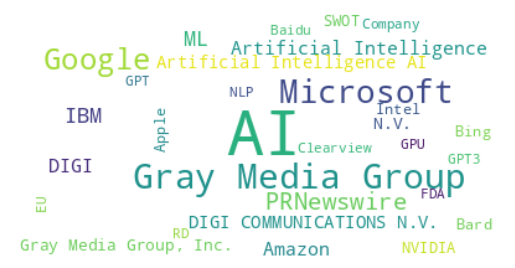

In [19]:
# plot a word cloud
from wordcloud import WordCloud

word_counts = spacy_org_sen_top30.set_index('Entities')['count'].to_dict()

# Create the word cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [20]:
# filter only the entities labelled as person and count the number of occurences
spacy_peo_sen_top30 = ner_spacy_ntext_sen_df[ner_spacy_ntext_sen_df['Labels'] == 'PERSON'].groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(30)
spacy_peo_sen_top30

,Entities,Labels,count
1388,CaptioningAudio,PERSON,116
3082,Googles,PERSON,105
7734,Twitter,PERSON,100
2430,Elon Musk,PERSON,72
7053,Size,PERSON,72
1000,Biden,PERSON,64
1283,C3 AI,PERSON,53
5246,Microsofts,PERSON,45
6736,Sam Altman,PERSON,41
5470,Musk,PERSON,39


/usr/local/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


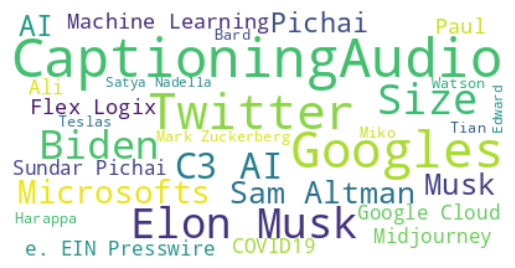

In [21]:
# plot a word cloud

word_counts = spacy_peo_sen_top30.set_index('Entities')['count'].to_dict()

# Create the word cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [22]:
# filter only the entities labelled as location and count the number of occurences
spacy_loc_sen_top30 = ner_spacy_ntext_sen_df[ner_spacy_ntext_sen_df['Labels'] == 'GPE'].groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(30)
spacy_loc_sen_top30

,Entities,Labels,count
1615,OpenAI,GPE,588
2245,US,GPE,476
2231,U.S.,GPE,409
991,India,GPE,350
446,China,GPE,348
2239,UK,GPE,220
1050,Japan,GPE,166
403,Canada,GPE,148
2656,the United States,GPE,132
26,AI,GPE,119


/usr/local/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


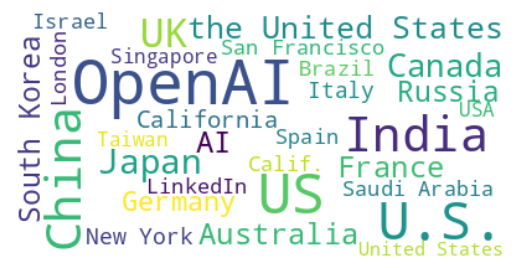

In [23]:
# plot a word cloud

word_counts = spacy_loc_sen_top30.set_index('Entities')['count'].to_dict()

# Create the word cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Without Sentence Segmentation

In [24]:
def extract_entities(df):
    with mp.Pool() as pool:
        results = pool.imap_unordered(process_text, df['cleaned text'], chunksize=2000)
        for i, ents in enumerate(results):
            for ent in ents:
                yield df.iloc[i]['id'], ent[0], ent[1]

In [25]:
%%time

ner_spacy_ntext_df = pd.DataFrame(extract_entities(df_news), columns=['id', 'Entities', 'Labels'])
ner_spacy_ntext_df

CPU times: user 7.27 s, sys: 200 ms, total: 7.47 s
Wall time: 2min 58s


,id,Entities,Labels
0,6559,GoodDeepali KhannaContributorOpinions,PERSON
1,6559,Forbes Contributors,ORG
2,6559,FacebookShare,ORG
3,6559,TwitterShare,ORG
4,6559,LinkedinThis,ORG
...,...,...,...
118050,185558,Italys,ORG
118051,185558,FBI,ORG
118052,185558,stationsMusk,FAC
118053,185558,Twitters,FAC


In [26]:
# group by entities and labels
ner_spacy_ntext_df.groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(10)

,Entities,Labels,count
5409,AI,ORG,8006
18811,Gray Media Group,ORG,926
40990,first,ORDINAL,862
25771,Microsoft,ORG,795
41968,one,CARDINAL,696
18560,Google,ORG,660
28427,OpenAI,GPE,566
45129,today,DATE,508
2108,2021,DATE,504
37340,US,GPE,477


In [27]:
# filter only the entities labelled as organization and count the number of occurences
spacy_org_top30 = ner_spacy_ntext_df[ner_spacy_ntext_df['Labels'] == 'ORG'].groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(30)
spacy_org_top30

,Entities,Labels,count
186,AI,ORG,8006
7634,Gray Media Group,ORG,926
10865,Microsoft,ORG,795
7492,Google,ORG,660
12488,PRNewswire,ORG,381
8262,IBM,ORG,294
10246,ML,ORG,291
4717,DIGI,ORG,214
1719,Artificial Intelligence,ORG,213
1365,Amazon,ORG,209


/usr/local/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


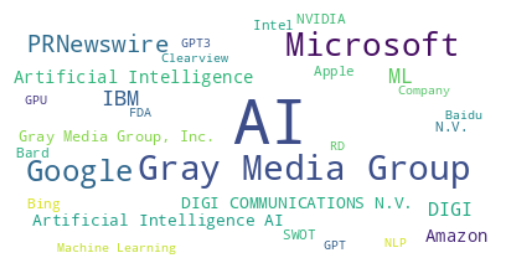

In [28]:
# plot a word cloud

word_counts = spacy_org_top30.set_index('Entities')['count'].to_dict()

# Create the word cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [29]:
# filter only the entities labelled as person and count the number of occurences
spacy_peo_top30 = ner_spacy_ntext_df[ner_spacy_ntext_df['Labels'] == 'PERSON'].groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(30)
spacy_peo_top30

,Entities,Labels,count
1422,CaptioningAudio,PERSON,116
3161,Googles,PERSON,104
7865,Twitter,PERSON,102
7183,Size,PERSON,72
2477,Elon Musk,PERSON,72
1025,Biden,PERSON,64
5574,Musk,PERSON,55
1317,C3 AI,PERSON,54
5351,Microsofts,PERSON,46
6861,Sam Altman,PERSON,41


/usr/local/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


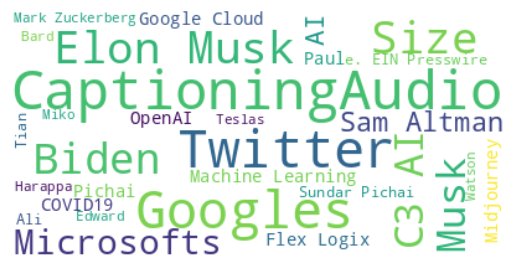

In [30]:
# plot a word cloud

word_counts = spacy_peo_top30.set_index('Entities')['count'].to_dict()

# Create the word cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [31]:
# filter only the entities labelled as location and count the number of occurences
spacy_loc_top30 = ner_spacy_ntext_df[ner_spacy_ntext_df['Labels'] == 'GPE'].groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(30)
spacy_loc_top30

,Entities,Labels,count
1587,OpenAI,GPE,566
2208,US,GPE,477
2194,U.S.,GPE,396
441,China,GPE,348
973,India,GPE,348
2202,UK,GPE,220
1031,Japan,GPE,166
399,Canada,GPE,148
2606,the United States,GPE,132
26,AI,GPE,118


/usr/local/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


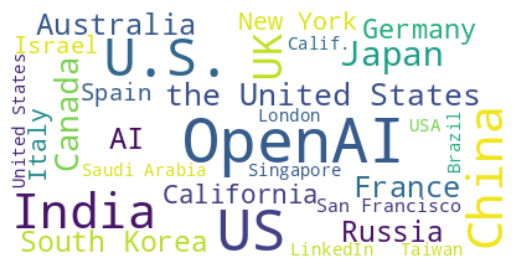

In [32]:
# plot a word cloud

word_counts = spacy_loc_top30.set_index('Entities')['count'].to_dict()

# Create the word cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()